<a href="https://colab.research.google.com/github/Arazsh/TensorFlow-in-Practice/blob/master/NaturalLanguageProcessing_LSTM_Tokenizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an example of Natural Language Processing (NLP) using TensorFlow. In this code, the sentences (sequences of words) in a body of text which are in fact parts of a poem, are tokenized and used to train a RNN that is equiped with LSTM layers. Then, a sentence is used as an input to the trained network in order to create new words that their sequence is similar to a poem itself. Since the dataset is fairly small and the model is simple, we cannat expect the model to create a real poem. But, creating new words based on the sequences of words can be one intresting application of NLP.  


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#loading necessary libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [ ]:
#Calling the Tokenizer
tokenizer = Tokenizer()
#Downlaoding the training sentences
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

#Reading the sentences and tokenizing the words
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-08-11 02:56:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-08-11 02:56:11 (92.8 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [ ]:
#Building the model with two LSTM layers. The l2 regularization is used to reduce the over-fitting issue. 
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [ ]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 13s 27ms/step - loss: 6.8982 - accuracy: 0.0223
Epoch 2/100
484/484 [==============================] - 13s 27ms/step - loss: 6.4999 - accuracy: 0.0226
Epoch 3/100
484/484 [==============================] - 13s 27ms/step - loss: 6.4047 - accuracy: 0.0254
Epoch 4/100
484/484 [==============================] - 13s 27ms/step - loss: 6.2927 - accuracy: 0.0295
Epoch 5/100
484/484 [==============================] - 13s 28ms/step - loss: 6.1953 - accuracy: 0.0351
Epoch 6/100
484/484 [==============================] - 13s 27ms/step - loss: 6.1096 - accuracy: 0.0399
Epoch 7/100
484/484 [==============================] - 13s 27ms/step - loss: 6.0376 - accuracy: 0.0404
Epoch 8/100
484/484 [==============================] - 13s 27ms/step - loss: 5.9518 - accuracy: 0.0466
Epoch 9/100
484/484 [==============================] - 13s 27ms/step - loss: 5.8552 - accuracy: 0.0521
Epoch 10/100
484/484 [==============================] - 13s 27ms/step - l

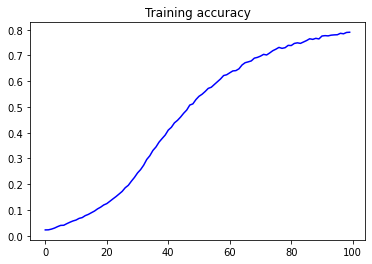

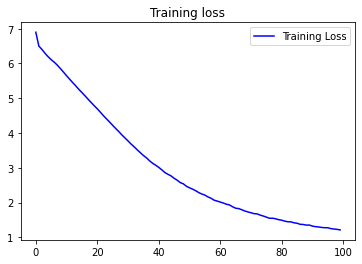

In [ ]:
#Plotting loss and accuracy VS epochs
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
#Creating a poem by using the seed sentence as the input sequence of words
#100 new words are going to be created 
seed_text = "Look in thy glass, and tell the face thou viewest"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Look in thy glass, and tell the face thou viewest room room room give thee so long form back alone well new parts of show him me me in thee are bring that mine own sight are view increase rare seen seen pride leaves rolling out well hours of sinful rolling parts of thee now prove thee alone dear heart away seem worth in fullness leave well foes blot the truth in store in loss or loss no fire out up afloat quite gone and all too dead mother bright eye new delight seen hate sang painted worth of thine best ' show me more own brow rhyme happy might
